# Practical Session 5 - Parallel Markov chains with multiprocessing and dask

Students (pair):
- [BENICHOU Yaniv](https://github.com/benech17)
- [BONNEFOY Nicolas](https://github.com/Nicolas-Bonnefoy)


**Useful references for this lab**:

[1] `seaborn`: [official tutorial](https://seaborn.pydata.org/tutorial.html)

[2] `multiprocessing`: [documentation](https://docs.python.org/3/library/multiprocessing.html), [doc2](https://he-arc.github.io/livre-python/multiprocessing/index.html)

[3] `dask`: [documentation](http://numba.pydata.org/) 

## <a name="content">Contents</a>
- [Exercise 1: seaborn, a useful tool for data visualisation](#ex1)
- [Exercise 2: Simulating a discrete-time homogeneous Markov chain](#ex2)
- [Bonus: Parallel computing with Dask](#bonus)
---

In [1]:
%load_ext autoreload
%autoreload 2



## <a name="ex1">Exercise 1: seaborn, a useful tool for data visualisation</a> [(&#8593;)](#content)
 
The `seaborn` package can significantly enhance data and data analysis visualization. See the [tutorial page](https://seaborn.pydata.org/tutorial.html) for examples of effective predefined graphics. An example aimed at visualizing the empirical distributions of 9 realizations of a bivariate Gaussian random vector is reported below.

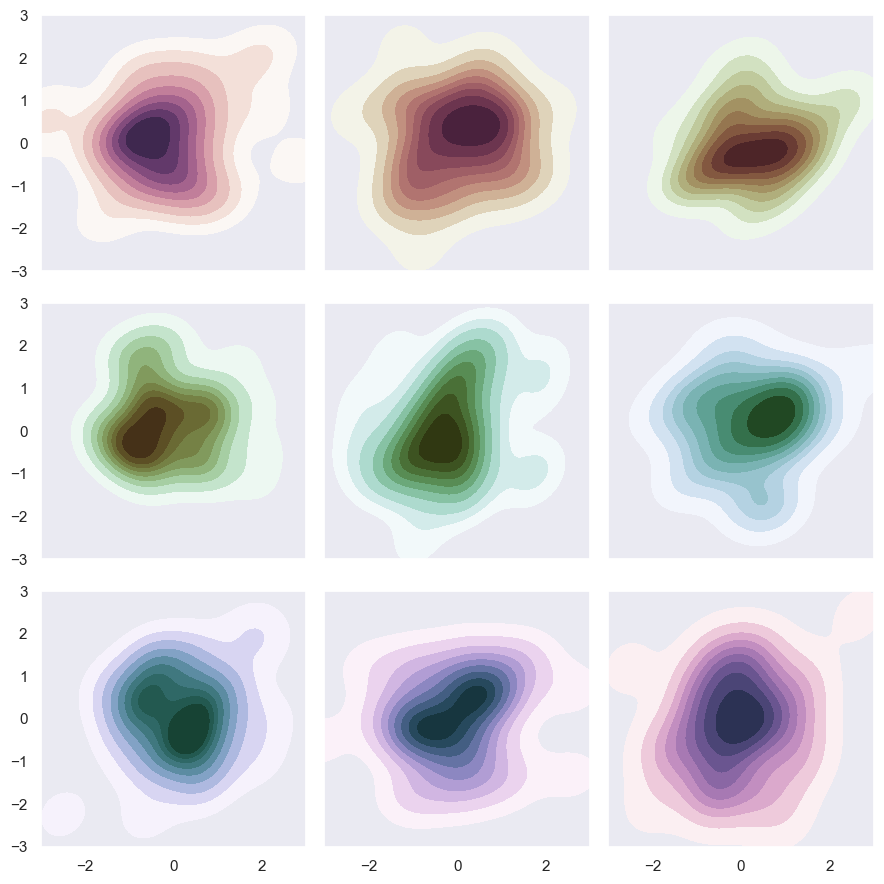

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

sns.set(style="dark")
rng = np.random.default_rng(50)

# Set up the matplotlib figure
f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)

# Rotate the starting point around the cubehelix hue circle
for ax, s in zip(axes.flat, np.linspace(0, 3, 10)):
    # Create a cubehelix colormap to use with kdeplot
    cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)

    # Generate and plot a random bivariate dataset
    x, y = rng.normal(size=(2, 50))
    sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, cut=5, ax=ax)
    ax.set(xlim=(-3, 3), ylim=(-3, 3))

f.tight_layout()

1. Comment on the lines of codes related to the `seaborn` library to make their role explicit. More specifically comment on the KDE method.

**Answer:**


> Tout d'abord la fonction `sns.set()` est utilisée pour définir le style esthétique et l'apparence du graphique, avec le style "dark". 
>
> Ensuite, la ligne `cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)` crée une palette de couleurs cubehelix à utiliser avec kdeplot plus tard gràce à la variable cmap.
> La palette cubehelix est conçue pour être bien interprétée lorsqu'elle est convertie en niveaux de gris. Ces paramètres sont :
> > * 'start' détermine le point de départ dans le cercle de teinte cubehelix avec l'itérateur s, qui prends ses valeurs directement dans le np.linespace(0, 3, 10), c'est à dire de 10 valeurs régulièrement espacés allant de 0 à 3. 
> > * 'light' définit la luminosité de la palette, avec un float allant de 0 à 1, avec 1 étant le plus clair.
> > * 'as_cmap=True' retourne un objet colormap au lieu d'une liste de couleurs.
>
> La méthode `sns.kdeplot` est utilisée pour afficher la densité de probabilité d'un ensemble de données.
> La technique de "Kernel Density Estimation" est une méthode non paramétrique pour estimer la fonction de densité de probabilité d'une variable aléatoire. Ces paramètres sont : 
> > * 'x' et 'y' sont les coordonnées des points de données.
> > * 'cmap' est la palette de couleurs utilisée pour colorer le tracé, créée précédemment.
> > * 'shade=True' remplit la région sous le KDE. Elle remplit les niveaux entre les courbes.
> > * 'cut' détermine la taille de l'extension du tracé au-delà des données. Plus cette valeur est élevée, plus le tracé s'étendra au-delà des données observées. 
>
> En somme, le tracé KDE est un moyen d'examiner la distribution et la densité des données. Au lieu de simplement compter les points dans un histogramme, le KDE utilise une fonction de lissage pour estimer la probabilité continue à travers une gamme. 


2. For one of the realizations, take a look at the documentation of [`sns.jointplot`](https://seaborn.pydata.org/examples/joint_kde.html) to display both the 2-D empirical distribution of the data, and 1D histograms of their distribution along each axis. 

**Answer:**

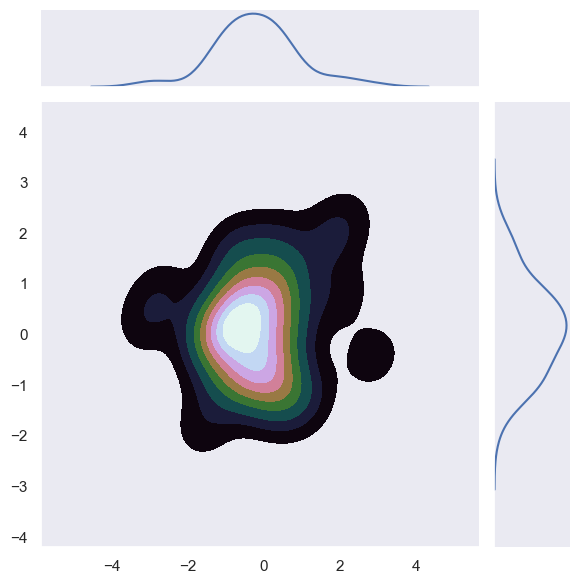

In [3]:
rng = np.random.default_rng(50)
x, y = rng.normal(size=(2, 50)) 
plot = sns.jointplot(x=x, y=y, kind='kde', cmap='cubehelix', shade=True, cut=5)
plt.show()

## <a name="ex2">Exercise 2: Simulating a discrete-time homogeneous Markov chain.</a> [(&#8593;)](#content)


Let ${(X_n)}_{n\geq 0}$ be a discrete-time homogeneous Markov chain with values over a finite ensemble $E=\{x_1,\dots,x_N\}$ identified to $\{1,\dots,N\}$. Consider $\boldsymbol{\rho} \in \Delta_N$, where $\Delta_N = \{\mathbf{x}\in\mathbb{R}^N \mid x_n \geq 0 \, \forall n \in \{1,\dotsc,N\} \text{ and } \sum_n x_n = 1 \}$ is the unit simplex in $\mathbb{R}^N$.

In the following, we consider the initial state of the chain $X_0$, following the discrete probability distribution:

$$
    \mathbb{P}(X_0 = k) = \rho_k, \qquad k \in \{1, \dots,  N\}.
$$
  
Let $\mathbf{A} = [a_{i,j}]_{i,j} \in \mathbb{R}^{N \times N}$ be the transition matrix of the chain, i.e.,

\begin{align*}
    &a_{i,j} = \mathbb{P}(X_{n+1} = j \mid X_{n} = i) \geq 0, \, \forall n \geq 0, \\
    &(\forall i \in \{1, \dotsc, N\}), \quad \sum_{j=1}^N a_{i,j} = 1.
\end{align*}
 
The chain is said to be homogeneous in that $\mathbf{A}$ does not depend from the time index $n$. Let $\tilde{a}_n$ represent the $n$-th row of $\mathbf{A}$. 

The trajectory of the chain can be simulated as follows:

>- Draw the discrete random variable $X_0$ with distribution $\boldsymbol{\rho}$;
>
>- For $q = 0$ to $n_{\text{iter}}-1$
>    - Draw the discrete random variable $X_{q+1}$ with distribution $\tilde{a}_{X_{q}}$;
>    
>- Return ${(X_q)}_{0 \leq q \leq n_{\text{iter}}}$.


<!-- If $X_n = k$, we know that $T$, the life time of the chain in the state $k$ obeys a geometric distribution with parameter $a_{kk}$. We also know that the probability of transition from k to $\ell\neq k$ is given by:

$$
    \mathbb{P}(X_{n+1}=\ell | X_n=k, \ell\neq k) = \frac{a_{k\ell}}{1-a_{kk}}.
$$

 ### One possible algorithm to simulate a Markov chain is therefore:

    a. generate the initial state $X_0$ according to the discrete law $\{\rho_1,\dots,\rho_N\}$.

    b. at instant $n$, knowing that $X_n=k$,

    i) determine the life time $T$ in state $X_n=k$ by simulating a geometrical variable with parameter $a_{kk}$. As a consequence $X_n = \dots = X_{n+T} = k$. When $T=0$, we simply still have $X_n=k$.

    ii) determine next transition instant $n+T$, and determine the next state by using the probabilities of transition. -->

1. Implement the above algorithm in a function `X = markov(rho,A,nmax,rng)` with:
     - `rho`: law of the initial state (nonnegative vector of size $N$, summing to 1),
     - `A`: transition matrix (of size $N\times N$) 
     - `nmax`: number of time steps,
     - `rng`: random number generator
     - `X`: trajectory of the chain.
     
In particular, check the input parameters `A` and `rho` make sense by adding appropriate assertions (or raising exceptions).
   - Examples : **transition matrix `A` should be square** ; **expected `A` to be a stochastic matrix** ; **verify if the size of `A` and `rho` are consistent** ; **verify if `rho` is in the unit simplex**
     - `np.allclose`, `np.isclose` and `np.all` could be useful

> Hints:
> - the function `np.random.choice` can be useful to draw discrete random variables.
> - use `states = np.arange(N)` to create the the labels of the states (from $0$ up to $N-1$)

Here is an example of execution : 
![alternatvie text](img/For_CourseM.png)

**Answer:**

In [4]:
import numpy as np


def markov(rho,A,nmax,rng):
    n = A.shape[0]
    m = A.shape[1]
    assert n == m , "A is not square"
    assert n == len(rho), "rho and A have different dimensions"
    assert rho.sum() == 1, "rho does not sum to 1"
    assert np.all(A >= 0), "A has negative elements"
    assert np.all(A.sum(axis=1) == 1), "A does not sum to 1"
    np.random.seed(rng)
    X=np.zeros((nmax),dtype=int)
    for k in range(nmax):
        if k == 0:
            X[k] = np.random.choice([i for i in range(1,n+1)],1,p=rho)
        else:
            X[k] = np.random.choice([i for i in range(1,n+1)],1,p=A[X[k-1]-1,:])
            
    return X

2. Set the random number generator to a known state. Make a few simulations using simple transition matrices (*i.e.*, taking any nonnegative matrix $A=(a_{i,j})$ such that its lines sum to 1) and display the trajectory of the chains.

**Answer:**

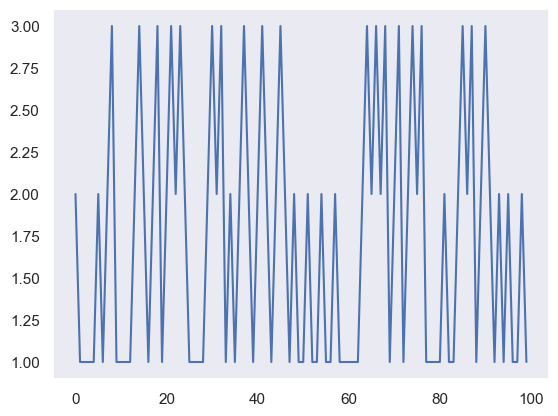

In [5]:
import matplotlib.pyplot as plt
import timeit
A=np.array([[0.5,0.5,0],[0.5,0,0.5],[0.5,0.5,0]])
rho=np.array([0.25,0.75,0])
nmax=100
rng=50
X=markov(rho,A,nmax,rng)
plt.plot(X)
plt.show()

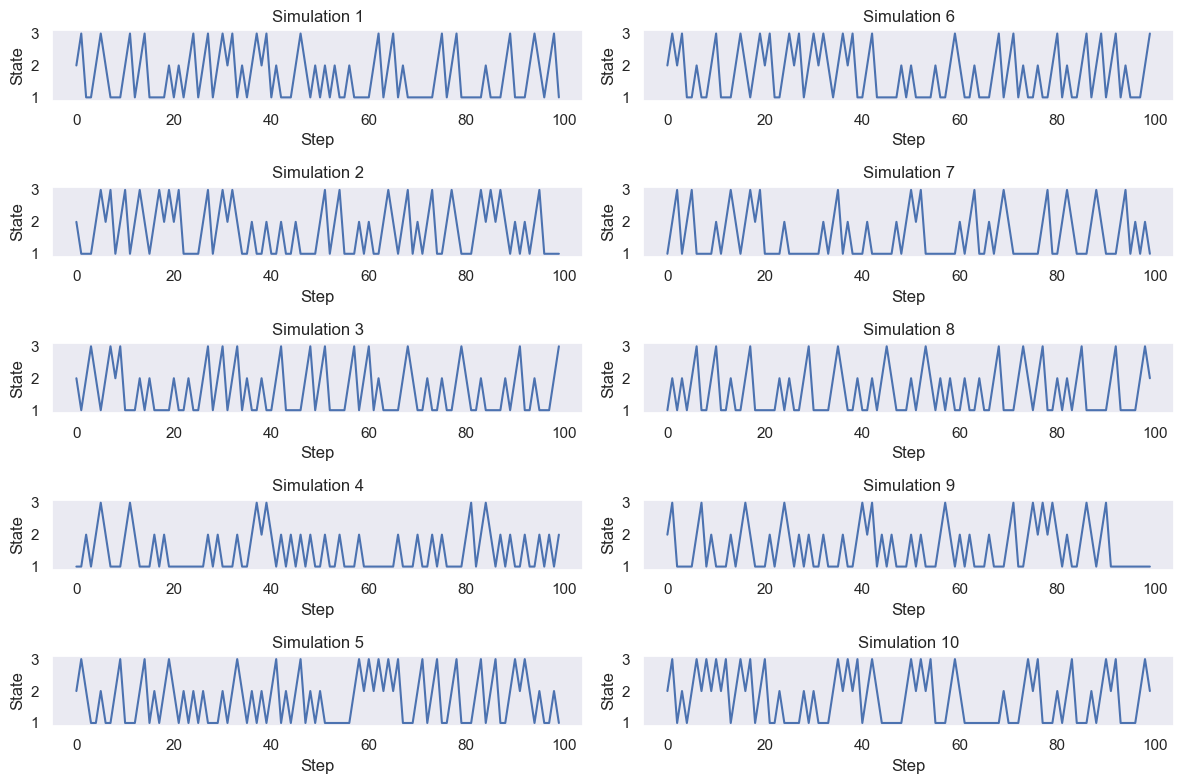

In [6]:


num_simulations = 100  # Adjust this as needed
rngs=np.random.randint(0, 1000, 10)

num_rows = 2  # Adjust as needed
num_cols = len(rngs) // num_rows

fig, axs = plt.subplots(num_cols, num_rows, figsize=(12, 8))

R=[]
for rng in rngs:
    r=markov(rho,A,nmax,rng)
    R.append(r)

for i, r in enumerate(R):
    col = i // num_cols
    row = i % num_cols
    ax = axs[row, col]
    ax.plot(r)
    ax.set_title(f'Simulation {i + 1}')
    ax.set_xlabel('Step')
    ax.set_ylabel('State')
    
plt.tight_layout()
plt.show()

3. Explore the potential of the [`multiprocessing` package](https://docs.python.org/3/library/multiprocessing.html) to simulate several Markov chains in parallel.

> Hint: the `mutiprocessing.Pool.starmap` or `mutiprocessing.Pool.starmap_async` methods could be useful.

**Answer:**

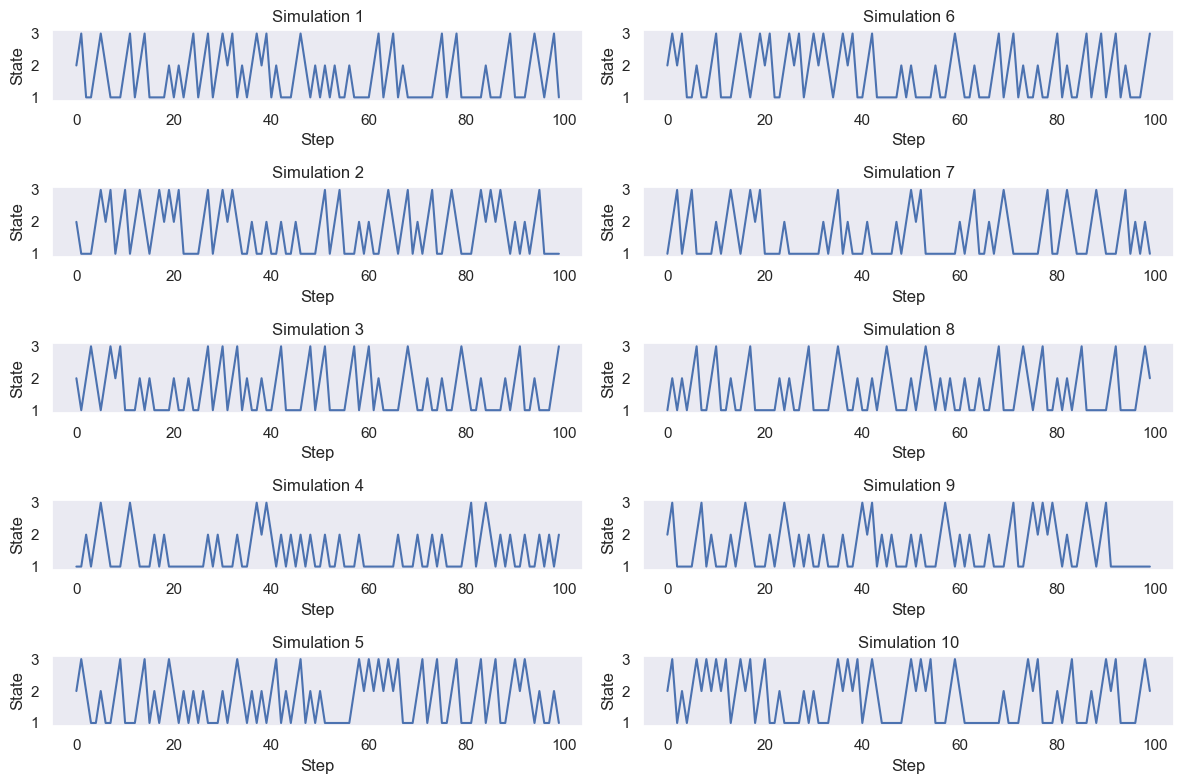

In [7]:

from multiprocessing import Pool
import defs

if __name__ == "__main__":
    # Number of processes to use in parallel
    num_processes = 4  # Adjust this as needed

    # Number of simulations to run in parallel
    num_simulations = 10  # Adjust this as needed

    # Seeds for random number generation (you can generate these as needed)
    with Pool(processes=num_processes) as pool:
        r=pool.starmap(defs.markov, [(A,rho,nmax,rng) for rng in rngs] )
    pool.close()

fig, axs = plt.subplots(num_cols, num_rows, figsize=(12, 8))
for i, result in enumerate(r):
    col = i // num_cols
    row = i % num_cols
    ax = axs[row, col]
    ax.plot(result)
    ax.set_title(f'Simulation {i + 1}')
    ax.set_xlabel('Step')
    ax.set_ylabel('State')

plt.tight_layout()
plt.show()


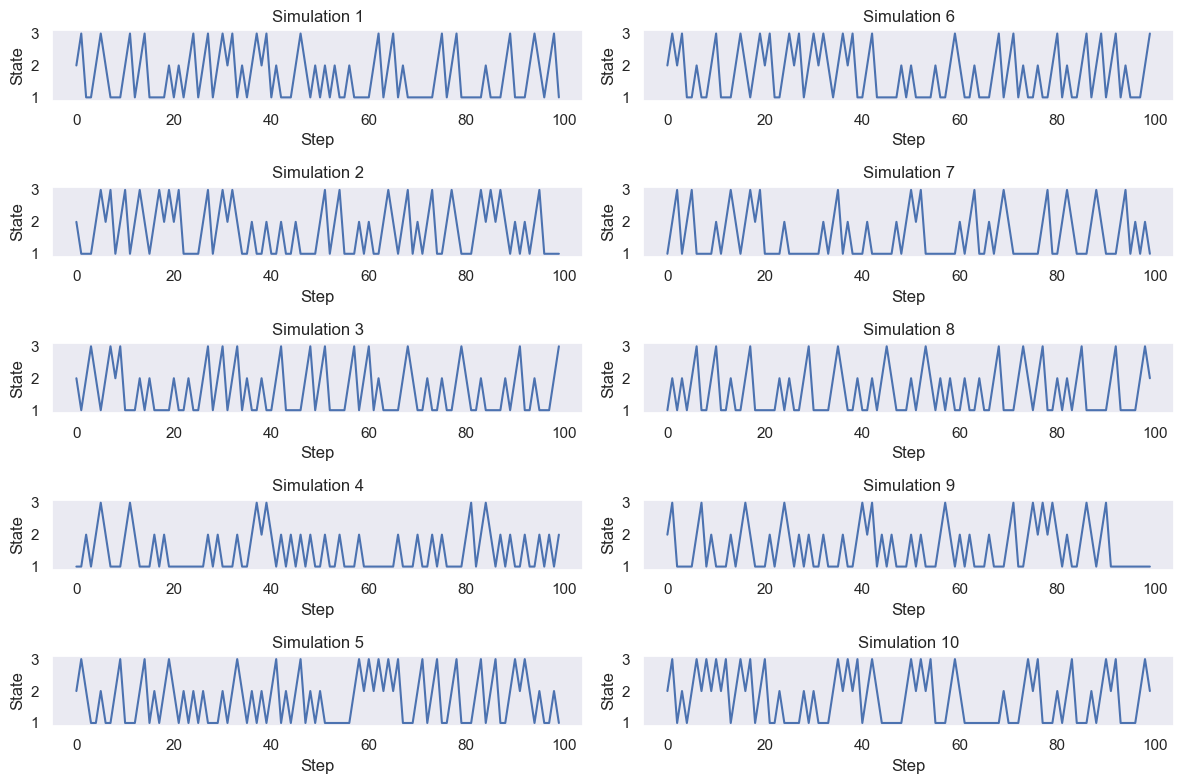

In [8]:

pool2=Pool(processes=num_processes)
result=pool2.starmap_async(defs.markov, [(A,rho,nmax,rng) for rng in rngs] ).get()
pool2.close()
fig, axs = plt.subplots(num_cols, num_rows, figsize=(12, 8))
for i, result in enumerate(r):
    col = i // num_cols
    row = i % num_cols
    ax = axs[row, col]
    ax.plot(result)
    ax.set_title(f'Simulation {i + 1}')
    ax.set_xlabel('Step')
    ax.set_ylabel('State')

plt.tight_layout()
plt.show()


In [9]:

import plotly.graph_objects as go
num_simulations=[50,100,200,300,400,500,600,700,800,900,1000]
num_processes=4
times1=[]
times2=[]
for num in num_simulations:
    rngs2=np.random.randint(0, 1000, num)
    start=timeit.default_timer()
    with Pool(processes=num_processes) as pool:
        r=pool.starmap(defs.markov, [(A,rho,num,rng) for rng in rngs2] )
    end=timeit.default_timer()
    print(end-start)
    times1.append(end-start)
    start=timeit.default_timer()
    for rng in rngs2:
        r=markov(rho,A,num,rng)
    end=timeit.default_timer()
    print(end-start)
    times2.append(end-start)

ratio=[times1[i]/times2[i] for i in range(len(times1))]
fig = go.Figure()
fig.add_trace(go.Scatter(x=num_simulations, y=ratio, mode='lines', name='Ratio'))

# Customize the layout of the plot
fig.update_layout(
    title='Ratio of Parallel Processing vs. Sequential Processing',
    xaxis_title='Number of Simulations',
    yaxis_title='Ratio (Parallel / Sequential)',
)

# Show the plot
fig.show()


0.3190951999999996
0.0797043999999989
0.3927718000000002
0.3122632999999997
0.7472729000000005
1.2617051000000004
1.2832142999999991
2.7905171000000024
1.9303036999999996
5.018432600000001
2.2815233
7.794737099999999
3.2397133999999994
11.424418699999997
4.147135599999999
15.455773699999995
5.444721400000006
20.0672948
6.839582300000004
25.540086799999997
9.454912199999995
31.408343900000006


4. [Bonus] Generate Markov chains in parallel with the [`dask`](https://docs.dask.org/en/latest/futures.html) library, which offers more general parallelization functionalities (with, for instance, the use of [`Futures`](https://docs.dask.org/en/stable/futures.html), see tutorial [here](https://tutorial.dask.org/05_futures.html)). A useful example is provided [here](https://stackoverflow.com/questions/41471248/how-to-efficiently-submit-tasks-with-large-arguments-in-dask-distributed). Note that `dask` is much more versatile and powerful than `multiprocessing`, and can be useful to scale algorithms over multiple cores and/or computing nodes.

**Answer:**

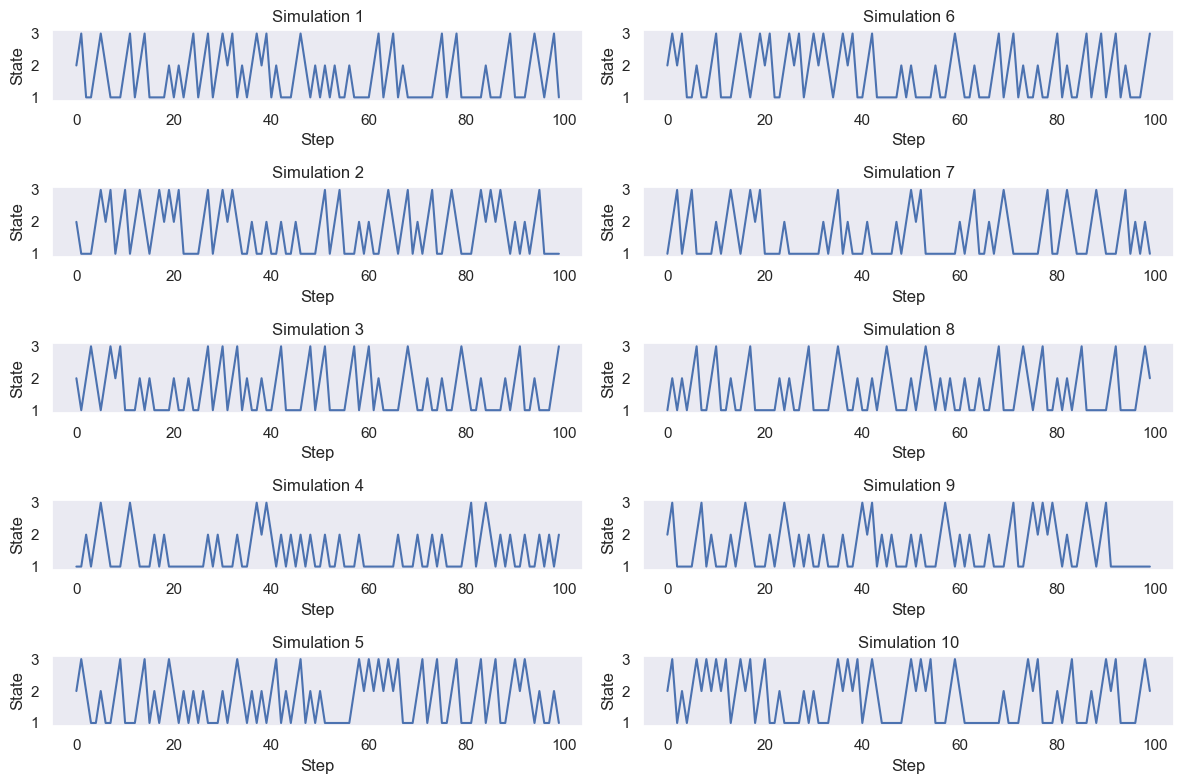

3.7153318000000013


In [13]:
#do the samemultitasking with dask
from dask.distributed import Client

start=timeit.default_timer()
client=Client(n_workers=5)
fig, axs = plt.subplots(num_cols, num_rows, figsize=(12, 8))
for i,rng in enumerate(rngs):
    r=client.submit(markov,rho,A,nmax,rng)
    col = i // num_cols
    row = i % num_cols
    ax = axs[row, col]
    ax.plot(r.result())
    ax.set_title(f'Simulation {i + 1}')
    ax.set_xlabel('Step')
    ax.set_ylabel('State')
    
plt.tight_layout()
plt.show()

#close all the clients
client.close()
end=timeit.default_timer()
print(end-start)

In [14]:
import plotly.graph_objects as go
num_simulations=[50,100,200,300,400,500,600,700,800,900,1000]
times1=[]
times2=[]
for num in num_simulations:
    rngs2=np.random.randint(0, 1000, num)
    start=timeit.default_timer()
    client=Client(n_workers=5)
    r=client.map(markov,[(rho,A,num,rng) for rng in rngs2])
    client.close()
    end=timeit.default_timer()
    print(end-start)
    times1.append(end-start)
    start=timeit.default_timer()
    for rng in rngs2:
        r=markov(rho,A,num,rng)
    end=timeit.default_timer()
    print(end-start)
    times2.append(end-start)

ratio=[times1[i]/times2[i] for i in range(len(times1))]
fig = go.Figure()
fig.add_trace(go.Scatter(x=num_simulations, y=ratio, mode='lines', name='Ratio'))

fig.update_layout(
    title='Ratio of Dask vs. Sequential Processing',
    xaxis_title='Number of Simulations',
    yaxis_title='Ratio (Dask / Sequential)',
)

# Show the plot
fig.show()


2.0046166999999855
0.081220500000029
2.0687237999999866
0.31283070000000635
2.06788320000004
1.2489843000000178
2.083595300000013
2.8463833000000136
2.066512799999998
5.146508900000015
1.9517298000000096
7.934057199999984
2.0596130999999787
11.351835600000015
1.9797113999999851
15.599934200000007
2.237122499999998
20.061466499999995
2.0792217999999707
25.552533100000005
2.0352221999999642
31.574281600000006


## <a name="bonus">Bonus: Parallel computing with Dask</a> [(&#8593;)](#content)

1. Take a look at the [`dask.array` documentation](https://docs.dask.org/en/stable/array-best-practices.html) and the associate [tutorial](https://tutorial.dask.org/02_array.html). Apply some of the functions introduced herein and in the [documentation](https://docs.dask.org/en/stable/array-best-practices.html) to parallelize the computation of the total variation investigated during session 2. Note that you can combine `dask` and `numba` to obtain an overall more efficient implementation. Note that timing can be worse than Numpy (`dask.array` is more specifically interesting when the data do no fit in memory).

2. Take a look at the [`dask.delayed` tutorial](https://tutorial.dask.org/03_dask.delayed.html), and go through some of the examples provided. [Best practices with the `dask.delayed` interface](https://docs.dask.org/en/stable/delayed-best-practices.html) are summarized in the documentation.

> **Remark**: an alternative to Dask: the [Ray](https://docs.ray.io/en/latest/) library.

**Answer:**

In [11]:
import dask.array as da
import numpy as np

def total_variation(image):
    """Calculate the total variation for an image."""
    return np.sum(np.abs(np.diff(image)))


def dask_total_variation(image, chunks=(1000, 1000)):
    """Calculate the total variation for an image using Dask."""
    dask_image = da.from_array(image, chunks=chunks)
    return da.sum(da.abs(da.diff(dask_image))).compute()


In [ ]:
# Question 2 

def inc(x):
    return x + 1

def add(x, y):
    return x + y

@dask.delayed
def delayed_inc(x):
    return inc(x)

@dask.delayed
def delayed_add(x, y):
    return add(x, y)

x = delayed_inc(1)
y = delayed_inc(2)
z = delayed_add(x, y)

result = z.compute()